In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

In [6]:
df = pd.read_excel("premiums.xlsx")
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [8]:
df.shape

(50000, 13)

In [12]:
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.head(1)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053


In [14]:
df.isna().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

In [18]:
df.dropna(inplace=True)

In [20]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [26]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)

In [28]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.711842,23.021150,15766.810189
std,15.000378,1.498195,24.221794,8419.995271
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


In [34]:
df[df.number_of_dependants < 0]["number_of_dependants"].value_counts()

number_of_dependants
-1    40
-3    32
Name: count, dtype: int64

In [36]:
df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    49976.000000
mean         1.717284
std          1.491953
min          0.000000
25%          0.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

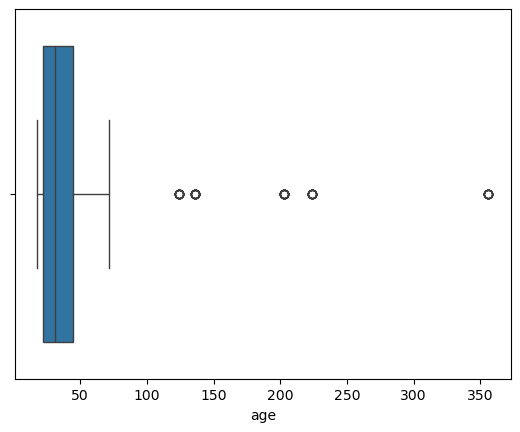

In [40]:
sns.boxplot(x=df['age'])
plt.show()

In [42]:
df1 = df[df.age<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49918.000000,49918.000000,49918.000000,49918.000000
mean,34.401839,1.717617,23.025141,15766.589286
std,13.681600,1.492074,24.227912,8419.137327
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22272.000000
max,72.000000,5.000000,930.000000,43471.000000


In [48]:
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

In [50]:
df1.income_lakhs.quantile([0.25, 0.75])

0.25     7.0
0.75    31.0
Name: income_lakhs, dtype: float64

In [52]:
get_iqr_bounds(df1.income_lakhs)

(-29.0, 67.0)

In [56]:
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

100.0

In [58]:
df2 = df1[df1.income_lakhs<=quantile_threshold].copy()

In [66]:
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49908.000000,49908.000000,49908.000000,49908.000000
mean,34.401579,1.717640,22.889897,15765.739641
std,13.681604,1.492032,22.170699,8418.674061
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22270.500000
max,72.000000,5.000000,100.000000,43471.000000


In [76]:
numeric_columns = df1.select_dtypes(include=["float64", "int64"]).columns

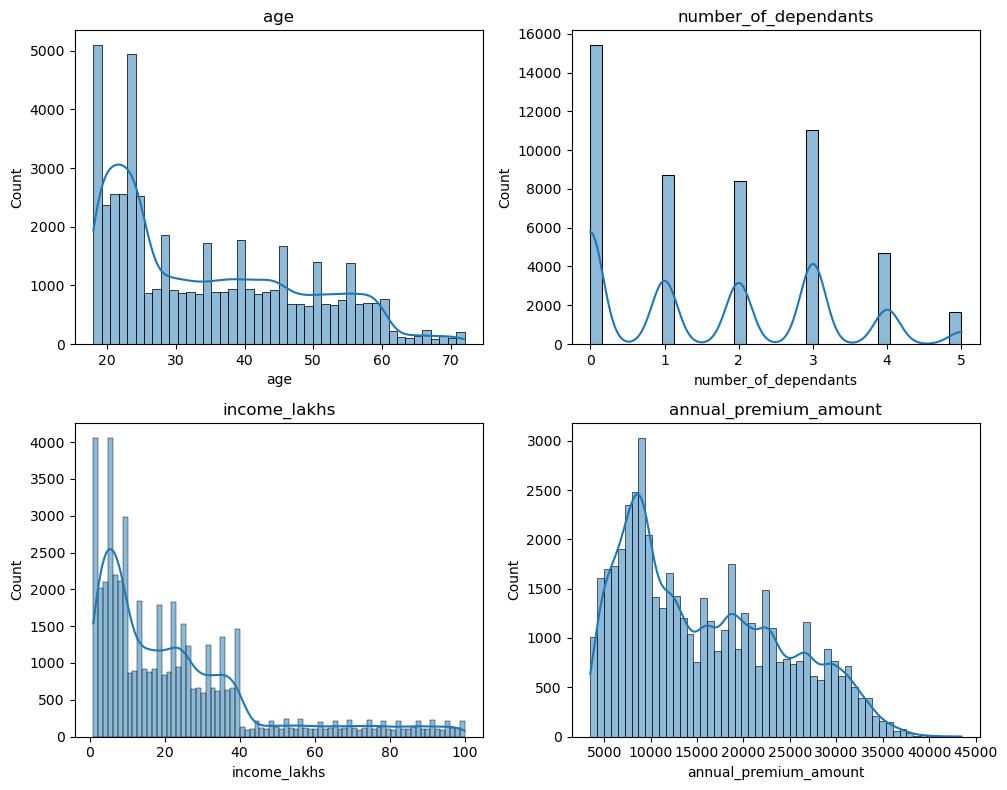

In [78]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))  # Adjust the size as necessary

for i, column in enumerate(numeric_columns):
    ax = axs[i//2, i%2]  # Determines the position of the subplot in the grid
    sns.histplot(df2[column], kde=True, ax=ax)
    ax.set_title(column)

plt.tight_layout()
plt.show()

<Axes: xlabel='age', ylabel='annual_premium_amount'>

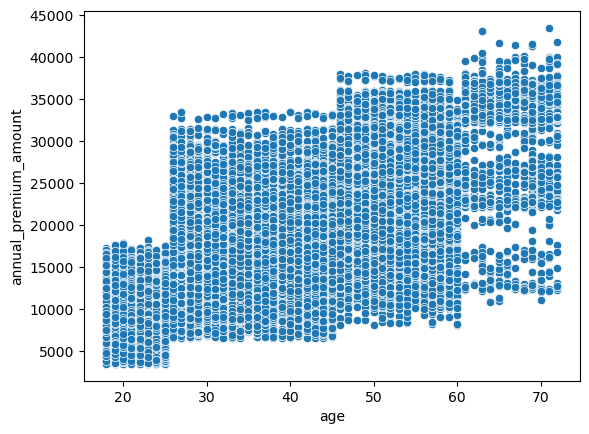

In [80]:
sns.scatterplot(df2, x='age', y='annual_premium_amount')

In [82]:
categorical_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'medical_history', 'insurance_plan']
for col in categorical_cols:
    print(col, ":", df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [86]:
df2['smoking_status'].replace({
    'Smoking=0':'No Smoking',
    'Does Not Smoke':'No Smoking',
    'Not Smoking':'No Smoking'
},inplace=True)
df2['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [94]:
pct_count = df2['gender'].value_counts(normalize=True)
pct_count

gender
Male      0.549631
Female    0.450369
Name: proportion, dtype: float64

<Axes: xlabel='gender'>

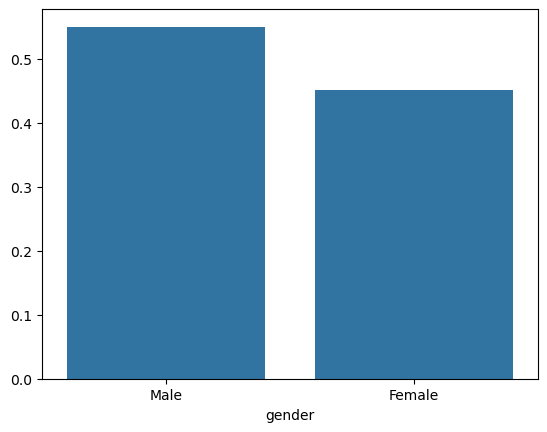

In [100]:
sns.barplot(x=pct_count.index, y=pct_count.values)

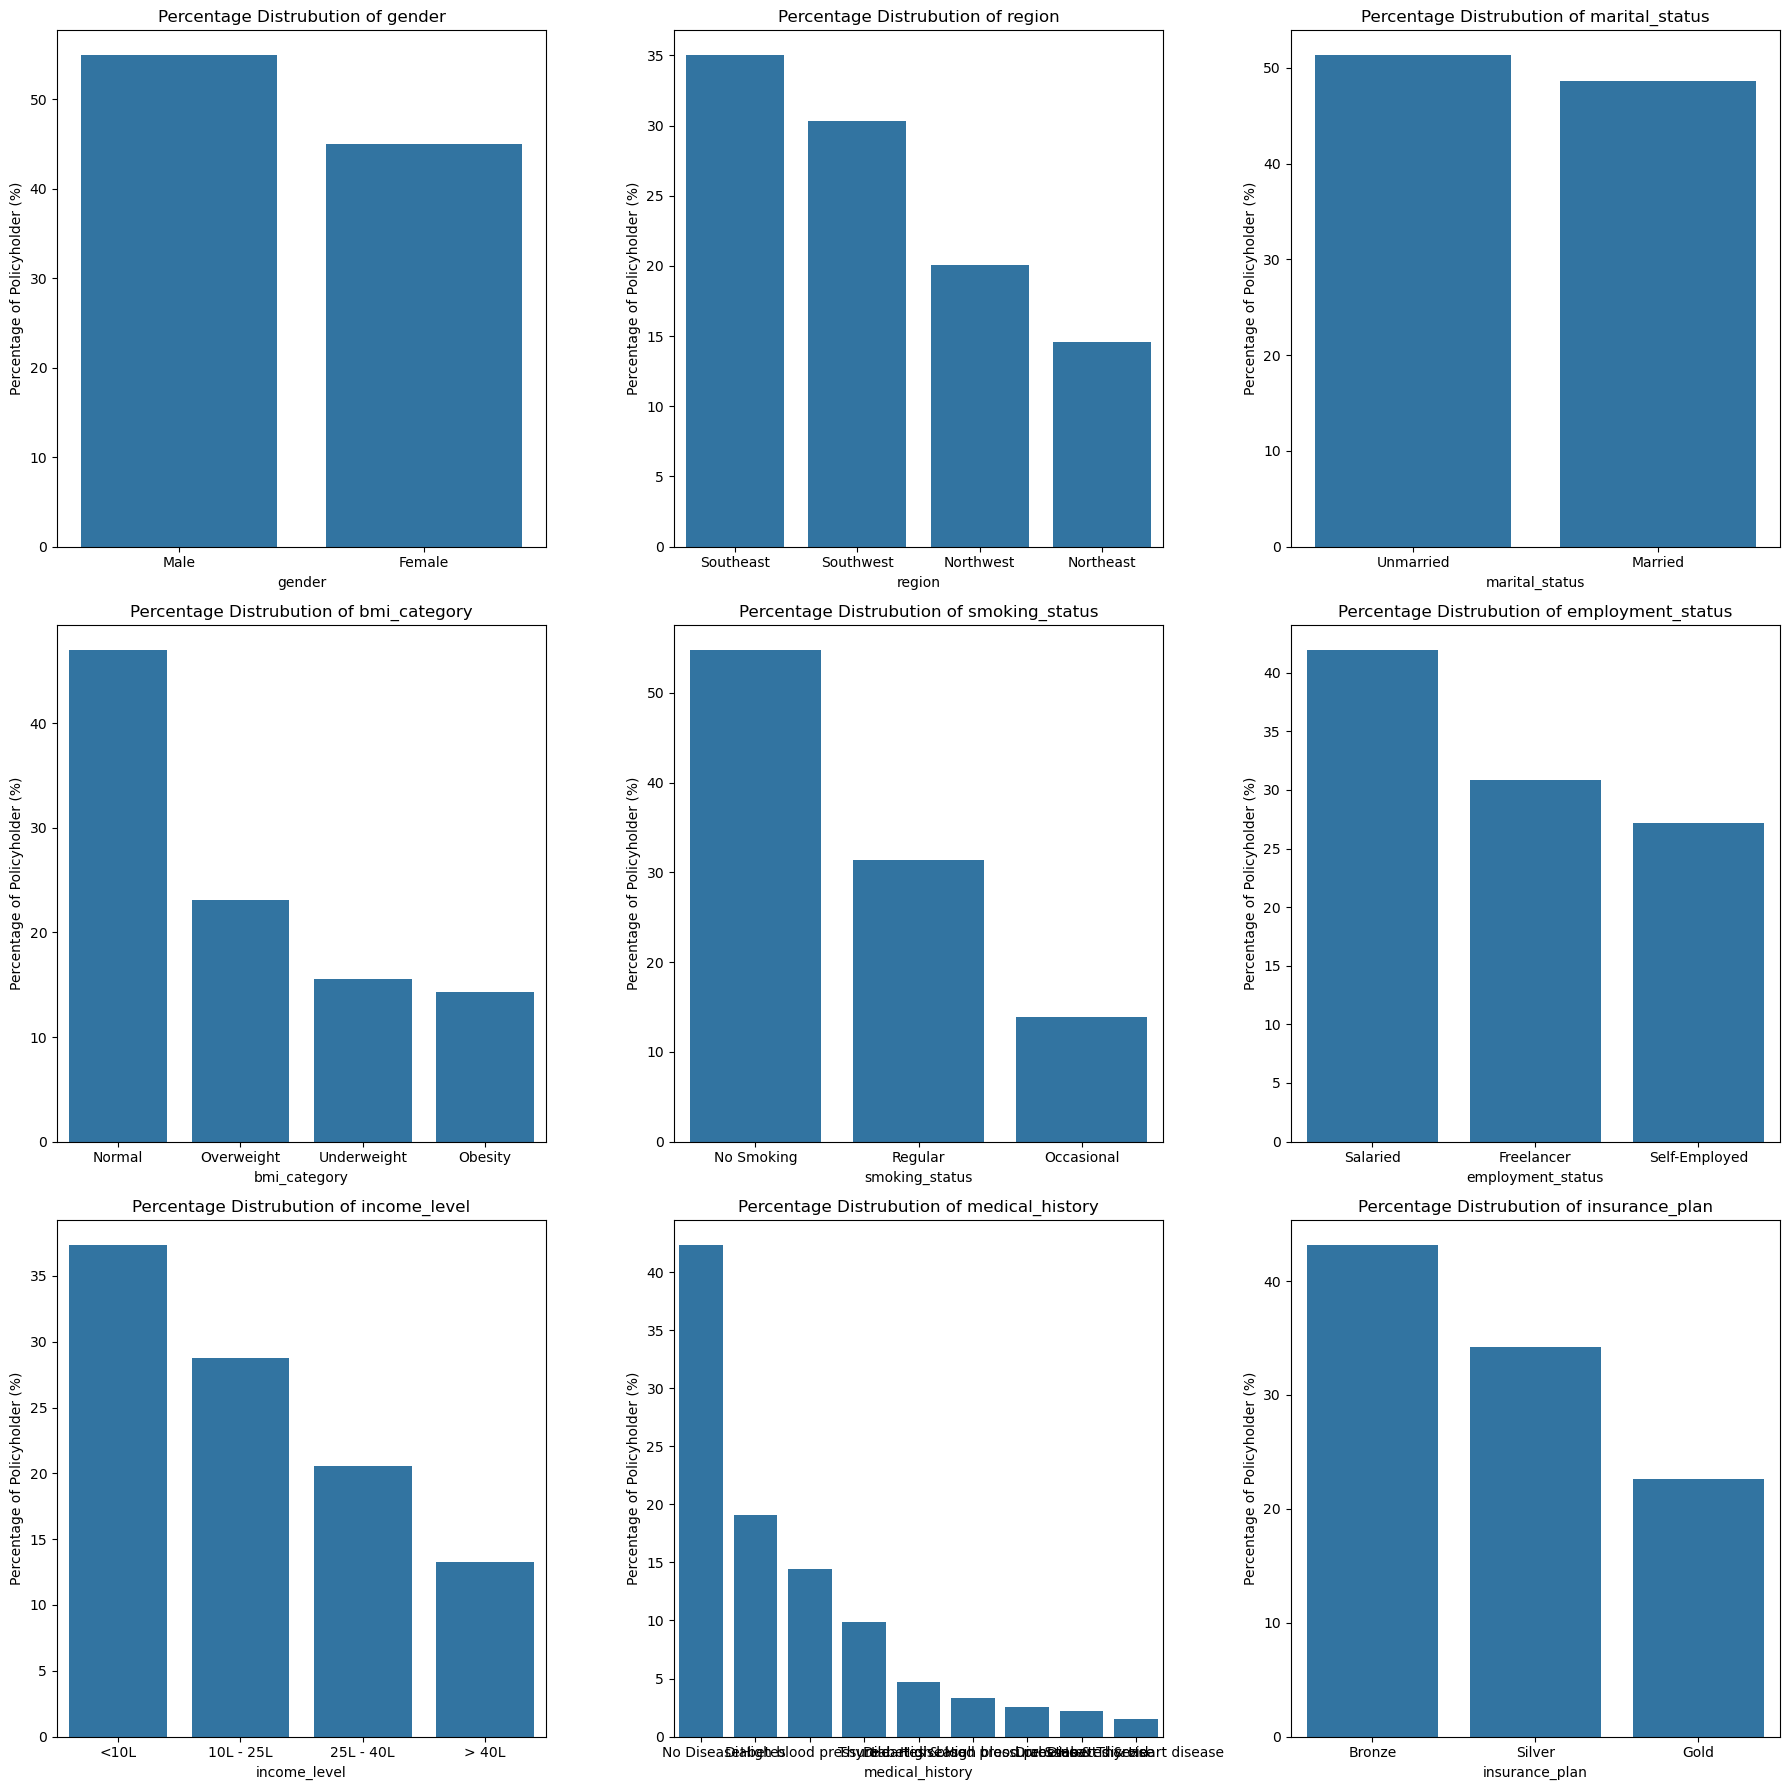

In [108]:
fig, axes = plt.subplots(3,3,figsize=(18,18))
axes = axes.flatten()

for ax, col in zip(axes, categorical_cols):
    categorical_cols = df2[col].value_counts(normalize=True)*100

    sns.barplot(x=categorical_cols.index, y=categorical_cols.values, ax=ax)
    ax.set_title(f'Percentage Distrubution of {col}')
    ax.set_ylabel('Percentage of Policyholder (%)')
    ax.set_xlabel(col)

plt.tight_layout()
plt.show()

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         5307  3880    5182
25L - 40L         3683  2840    3750
<10L             12226   931    5486
> 40L              329  3653    2641


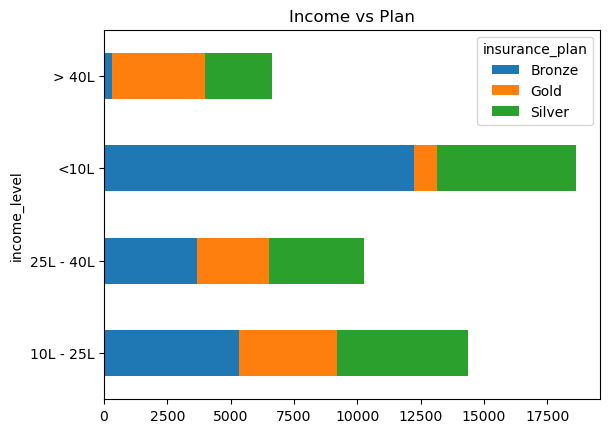

In [116]:
crosstab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
print(crosstab)
crosstab.plot(kind='barh', stacked=True)
plt.title('Income vs Plan')
plt.show()

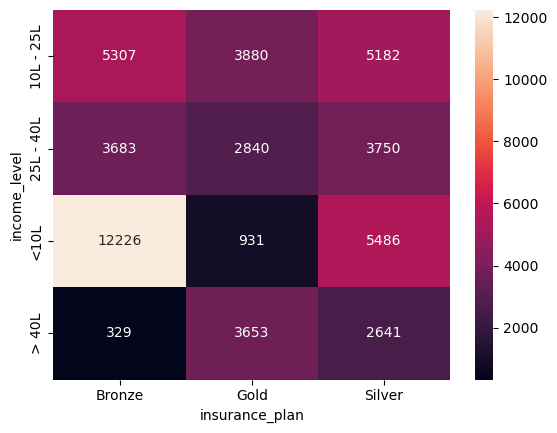

In [124]:
sns.heatmap(crosstab, fmt='d', annot=True)
plt.show()

In [126]:
df2.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [150]:
risk_scores = {
    "diabetes":6,
    "heart disease":8,
    "high blood pressure":6,
    "thyroid":5,
    "no disease":0,
    "none":0
}

df2[['disease1', 'disease2']] = df2['medical_history'].str.split(' & ', expand=True).apply(lambda x:x.str.lower())


In [157]:
df2['disease1'].fillna('none', inplace=True)
df2['disease2'].fillna('none', inplace=True)
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score)/ (max_score - min_score)
df2.sample(10)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
25454,40,Female,Southwest,Unmarried,0,Obesity,Occasional,Salaried,10L - 25L,12,Thyroid,Silver,20450,thyroid,none,5,0.357143
32090,22,Male,Northwest,Married,3,Normal,Regular,Self-Employed,25L - 40L,38,No Disease,Silver,10100,no disease,none,0,0.000000
23170,40,Male,Southwest,Married,3,Overweight,Regular,Freelancer,10L - 25L,21,High blood pressure & Heart disease,Silver,24060,high blood pressure,heart disease,14,1.000000
3724,24,Male,Southeast,Unmarried,0,Overweight,Occasional,Freelancer,<10L,4,High blood pressure,Bronze,5851,high blood pressure,none,6,0.428571
36374,57,Male,Southeast,Married,2,Normal,Regular,Self-Employed,> 40L,68,High blood pressure,Silver,21260,high blood pressure,none,6,0.428571
24781,23,Female,Southwest,Unmarried,0,Underweight,No Smoking,Salaried,<10L,1,No Disease,Bronze,5179,no disease,none,0,0.000000
25363,21,Male,Southwest,Unmarried,0,Normal,No Smoking,Salaried,10L - 25L,21,No Disease,Silver,10234,no disease,none,0,0.000000
21260,57,Male,Southeast,Unmarried,0,Overweight,Regular,Self-Employed,10L - 25L,25,Heart disease,Gold,35268,heart disease,none,8,0.571429
48870,23,Female,Northeast,Unmarried,0,Underweight,No Smoking,Freelancer,10L - 25L,25,No Disease,Bronze,7121,no disease,none,0,0.000000
35507,19,Male,Southeast,Married,3,Normal,Regular,Self-Employed,<10L,7,No Disease,Silver,9617,no disease,none,0,0.000000


In [159]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})

In [161]:
df2['income_level'] = df2['income_level'].map({'<10L':1, '10L - 25L': 2, '25L - 40L':3, '> 40L':4})

In [165]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,6,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,diabetes,none,6,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,6,...,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,No Disease,3,20303,no disease,none,0,...,1,0,0,0,0,0,0,0,1,0
4,18,0,4,99,High blood pressure,2,13365,high blood pressure,none,6,...,0,0,1,0,1,0,0,1,0,1


In [169]:
df4 = df3.drop(['medical_history','disease1', 'disease2', 'total_risk_score'], axis=1)
df4.head(3)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1


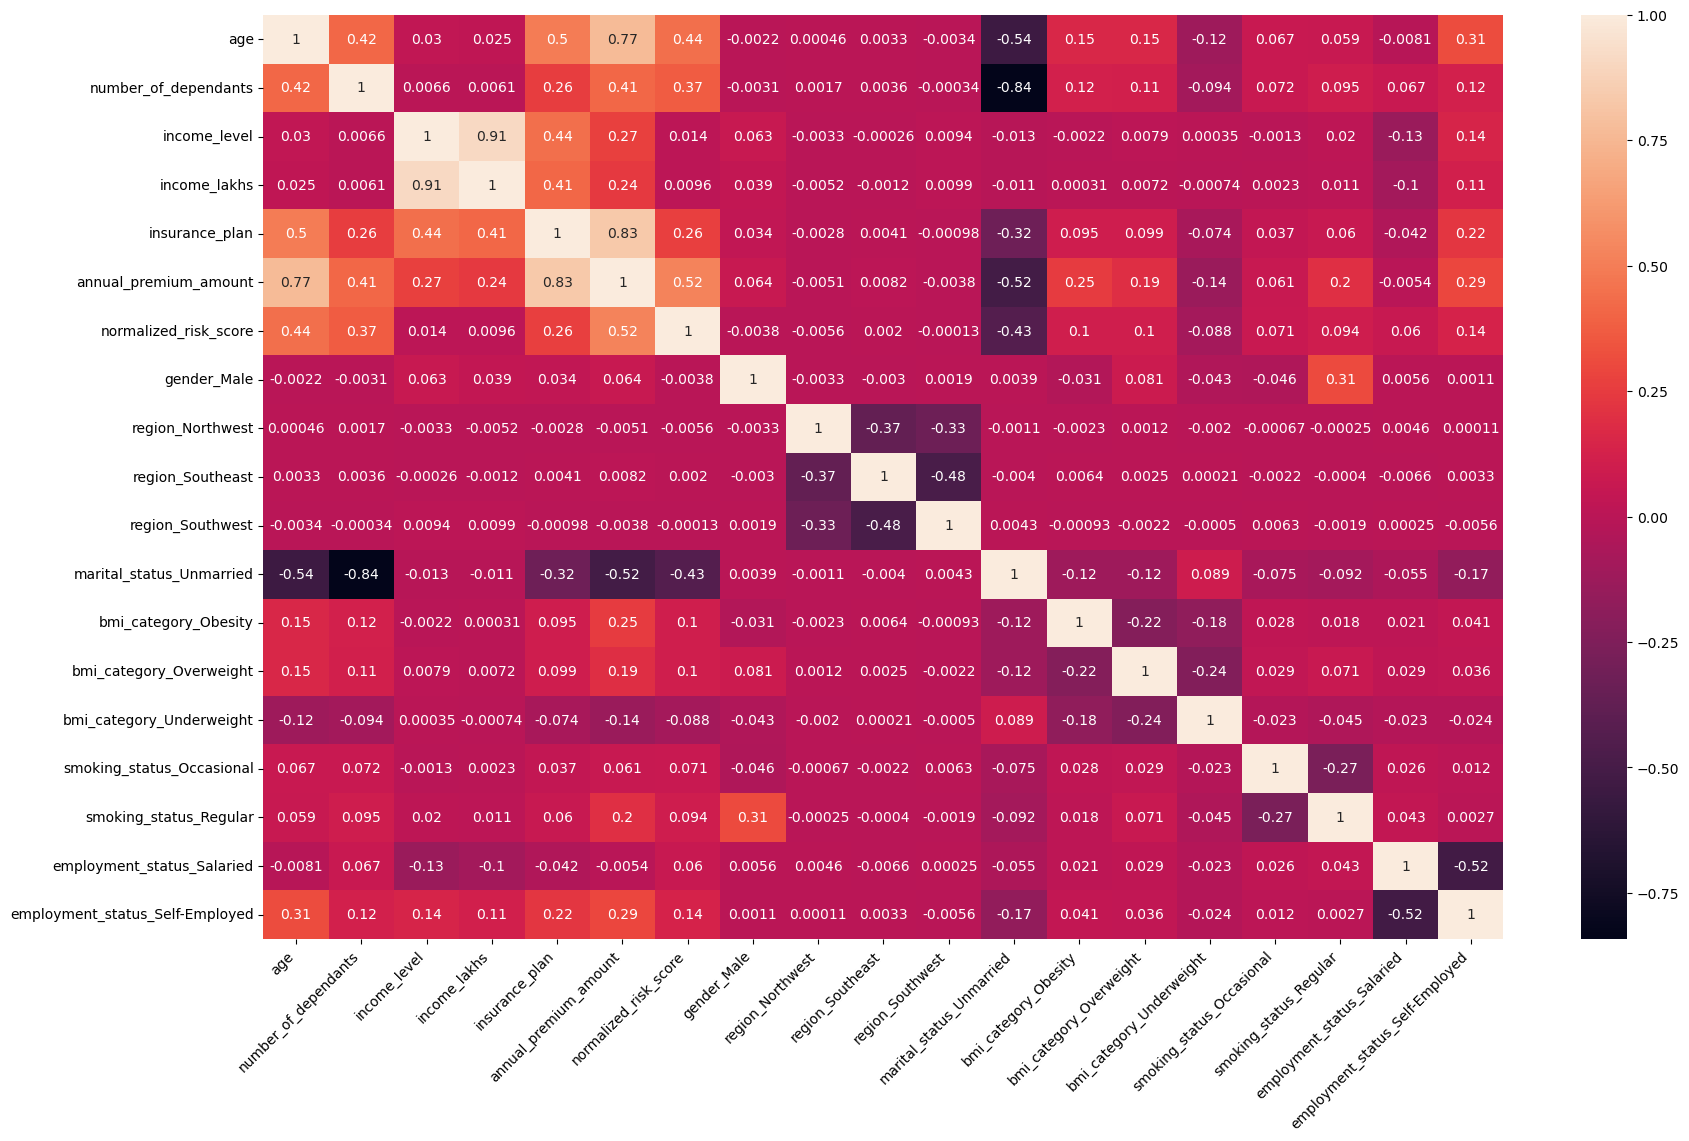

In [187]:
cm = df4.corr()
plt.figure(figsize=(20, 12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.show()

In [189]:
df4.head(2)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0


In [193]:
X = df4.drop('annual_premium_amount', axis=1)
y = df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler
cols_to_scale = ['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.148148,0.0,0.000000,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,0.000000,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,0.333333,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.222222,0.6,1.000000,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.000000,0.0,1.000000,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


In [199]:
X.shape

(49908, 18)

In [201]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_df

In [203]:
calculate_vif(X)

,Column,VIF
0,age,4.567634
1,number_of_dependants,4.534650
2,income_level,12.450675
3,income_lakhs,11.183367
4,insurance_plan,3.584752
5,normalized_risk_score,2.687610
6,gender_Male,2.421496
7,region_Northwest,2.102556
8,region_Southeast,2.922414
9,region_Southwest,2.670666


In [207]:
calculate_vif(X.drop("income_level" ,axis=1))

,Column,VIF
0,age,4.545825
1,number_of_dependants,4.526598
2,income_lakhs,2.480563
3,insurance_plan,3.445682
4,normalized_risk_score,2.687326
5,gender_Male,2.409980
6,region_Northwest,2.100789
7,region_Southeast,2.919775
8,region_Southwest,2.668314
9,marital_status_Unmarried,3.393718


In [209]:
X_reduced = X.drop('income_level', axis=1)
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.148148,0.0,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.222222,0.6,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.000000,0.0,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


### Model Train

In [212]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=10)

print("x train: ", X_train.shape)
print("x test: ", X_test.shape)
print("y train: ", y_train.shape)
print("y test: ", y_test.shape)

x train:  (34935, 17)
x test:  (14973, 17)
y train:  (34935,)
y test:  (14973,)


In [220]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score = model_lr.score(X_train, y_train)
test_score, train_score

(0.9280547230217837, 0.9282143576916762)

In [224]:
feature_importances = model_lr.coef_
pd.DataFrame(feature_importances, index=X_test.columns, columns=['Coefficients'])

,Coefficients
age,11160.926462
number_of_dependants,-676.443991
income_lakhs,-514.229816
insurance_plan,12557.012936
normalized_risk_score,4810.357702
gender_Male,168.646662
region_Northwest,-35.719292
region_Southeast,39.965130
region_Southwest,-24.652929
marital_status_Unmarried,-935.760611


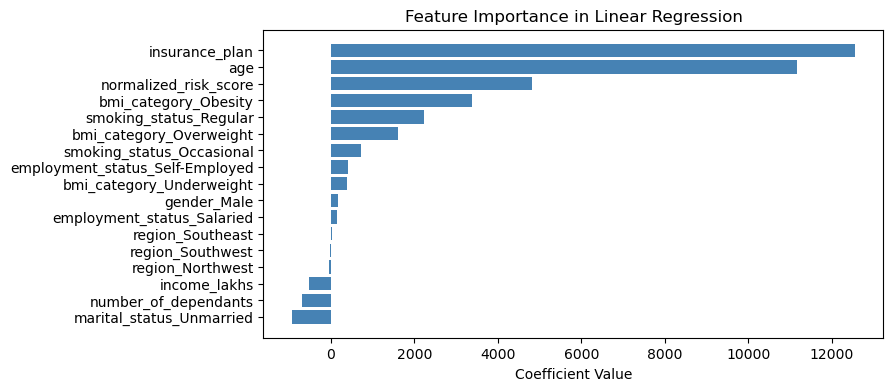

In [226]:
feature_importance = model_lr.coef_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

In [228]:
model_rg = Ridge(alpha=1)
model_rg.fit(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score = model_rg.score(X_train, y_train)
train_score, test_score

(0.9282143198366275, 0.9280541644640345)

In [234]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
model_xgb.score(X_test, y_test)

0.9809534637207582

In [236]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_score_

0.9809474553641963

In [237]:
best_model = random_search.best_estimator_

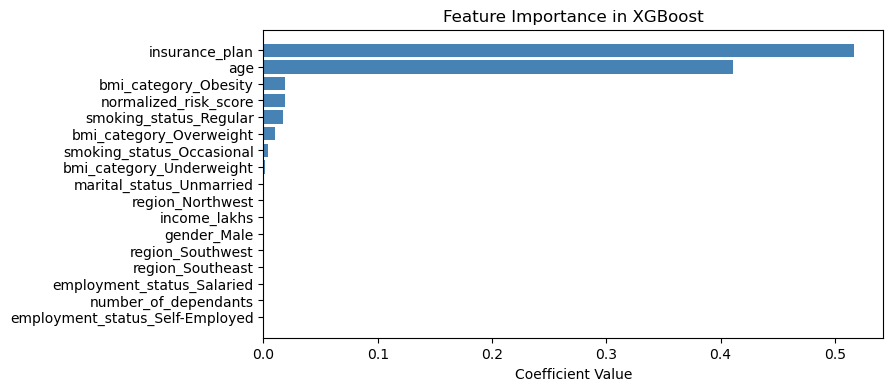

In [240]:
feature_importance = best_model.feature_importances_
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

In [242]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
rediduals_pct = (residuals / y_test) * 100

results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'diff': residuals,
    'diff_pct': rediduals_pct
})
results_df.head()

,actual,predicted,diff,diff_pct
3598,20554,20334.953125,-219.046875,-1.065714
35794,29647,29378.779297,-268.220703,-0.904714
43608,20560,20618.185547,58.185547,0.283004
42730,5018,7352.829590,2334.829590,46.529087
18936,8929,8203.291992,-725.708008,-8.127540


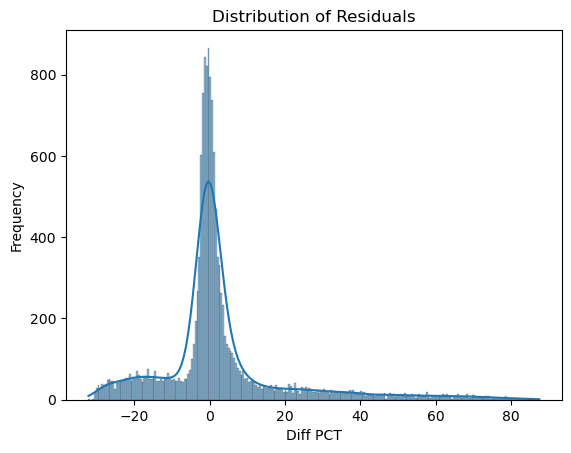

In [244]:
sns.histplot(results_df['diff_pct'], kde=True)
plt.title("Distribution of Residuals")
plt.xlabel('Diff PCT')
plt.ylabel('Frequency')
plt.show()

In [246]:
X_test.shape

(14973, 17)

In [250]:
extreme_error_threshold = 10
extreme_results_df = results_df[np.abs(results_df['diff_pct']) > extreme_error_threshold]
extreme_results_df

,actual,predicted,diff,diff_pct
42730,5018,7352.829590,2334.829590,46.529087
20029,5140,6670.849121,1530.849121,29.783057
4294,9631,7053.477539,-2577.522461,-26.762771
44419,4687,6670.849121,1983.849121,42.326629
6707,8826,10047.326172,1221.326172,13.837822
...,...,...,...,...
8767,8113,6565.852051,-1547.147949,-19.069986
25179,9944,7058.687988,-2885.312012,-29.015608
21592,8332,10615.658203,2283.658203,27.408284
49274,5571,6820.886230,1249.886230,22.435581


In [252]:
extreme_errors_pct = extreme_results_df.shape[0] * 100/ X_test.shape[0]

In [254]:
extreme_errors_pct

29.967274427302478

In [258]:
extreme_results_df[abs(extreme_results_df.diff_pct)>50].sort_values("diff_pct", ascending=False)

,actual,predicted,diff,diff_pct
36269,3501,6565.852051,3064.852051,87.542189
48801,3516,6565.852051,3049.852051,86.742095
42342,3521,6565.852051,3044.852051,86.476911
18564,3523,6565.852051,3042.852051,86.371049
7988,3527,6565.852051,3038.852051,86.159684
...,...,...,...,...
32671,4656,6994.980957,2338.980957,50.235845
14798,4371,6565.852051,2194.852051,50.213957
13736,4371,6565.852051,2194.852051,50.213957
10107,4710,7073.240723,2363.240723,50.174962


In [262]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head(2)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
42730,0.092593,0.2,0.131313,0.0,0.428571,1,0,0,0,1,0,1,0,0,0,0,0
20029,0.018519,0.2,0.030303,0.0,0.000000,0,1,0,0,1,0,0,1,0,0,1,0


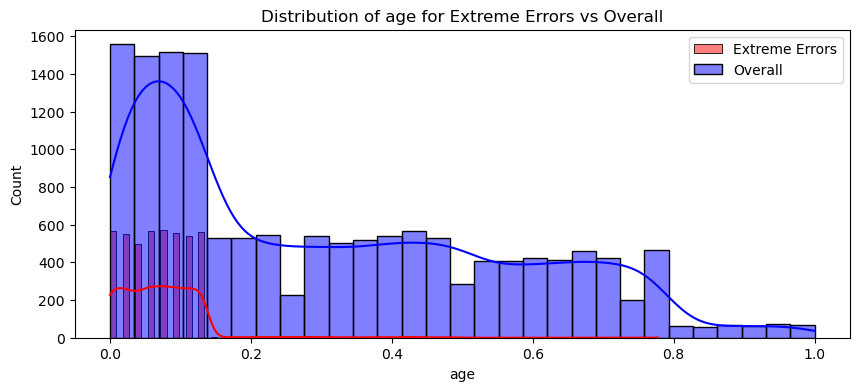

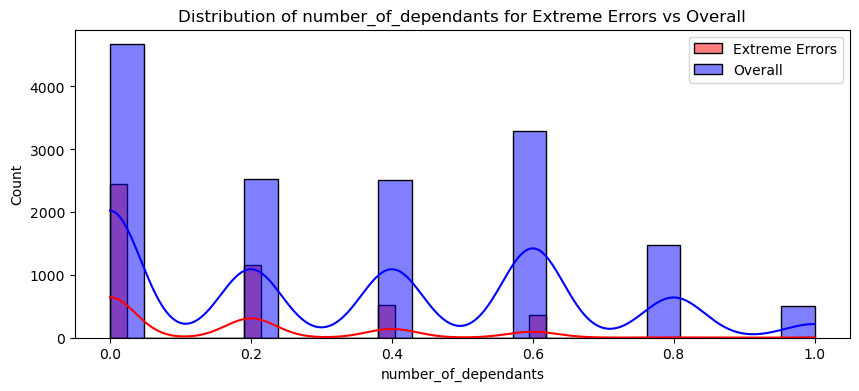

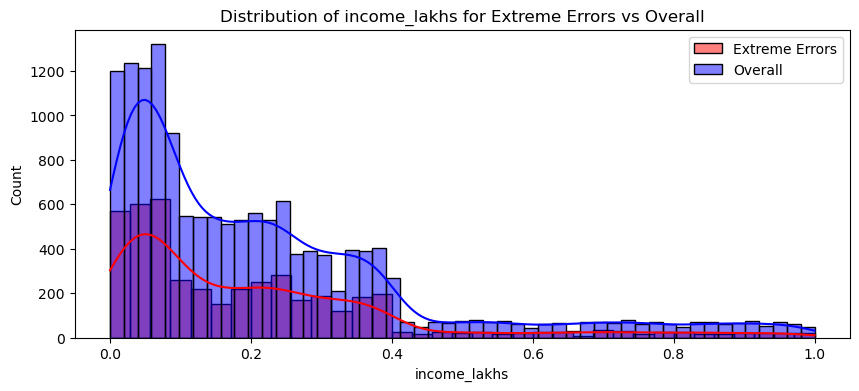

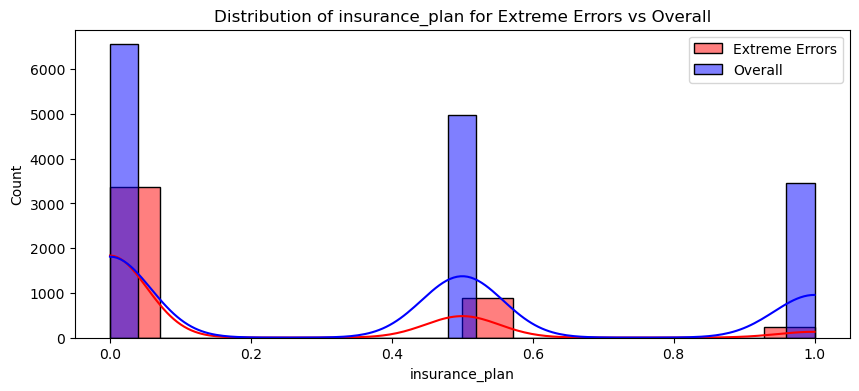

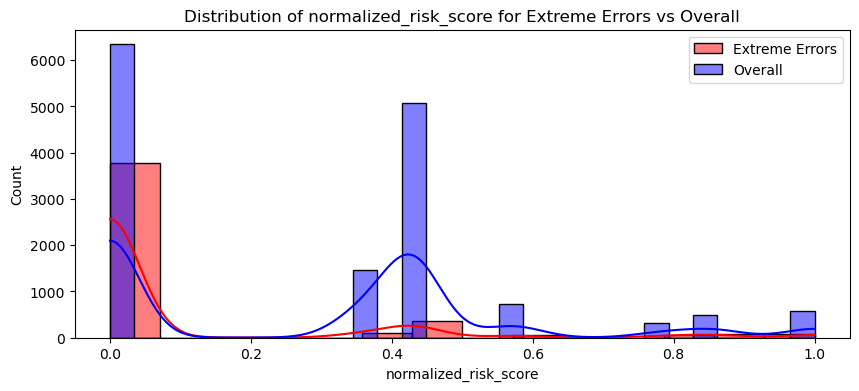

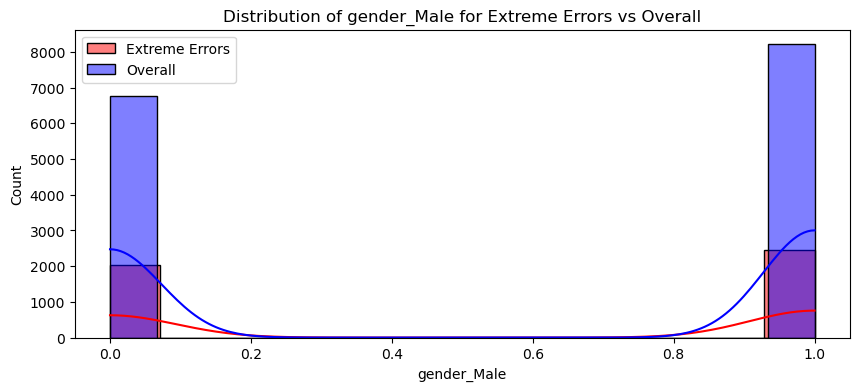

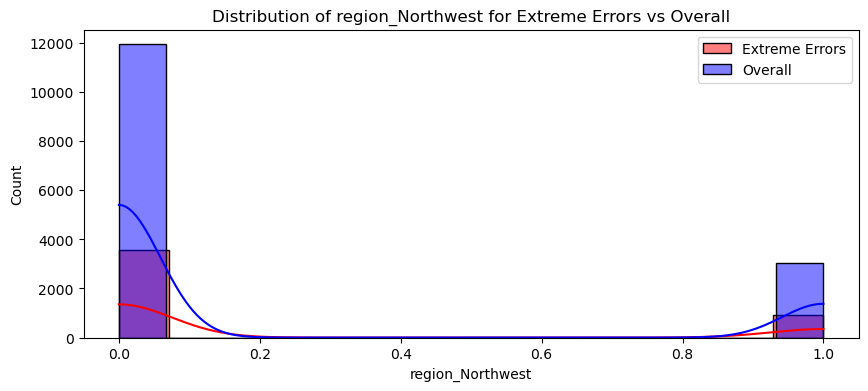

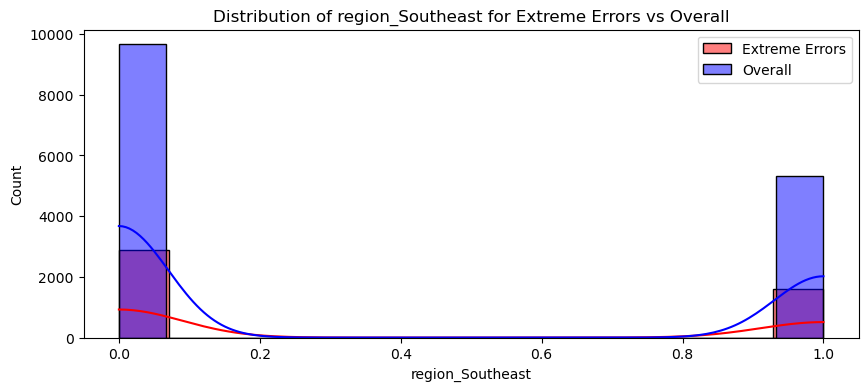

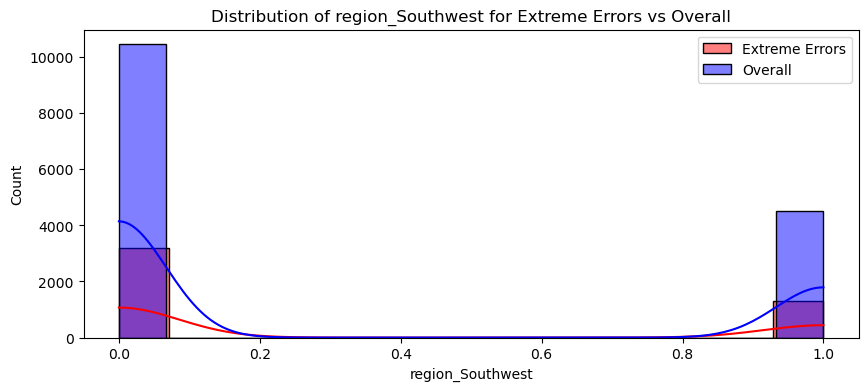

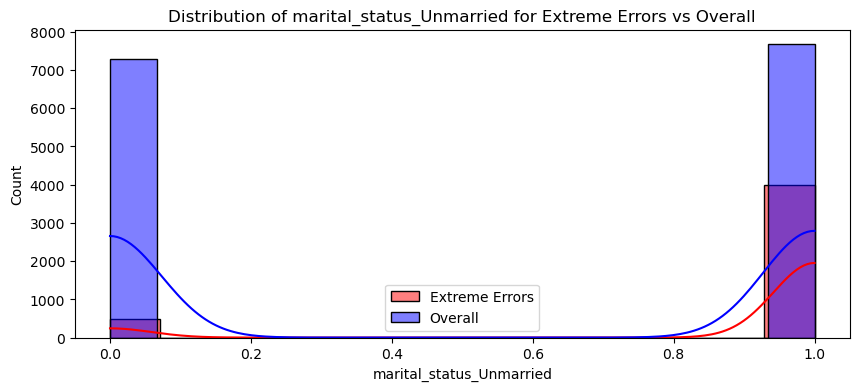

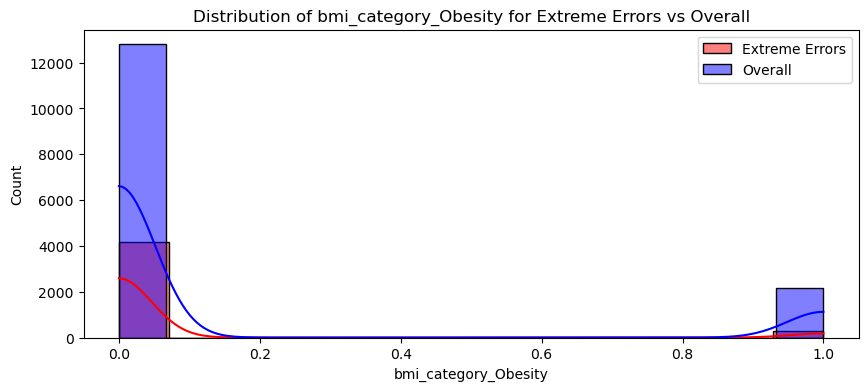

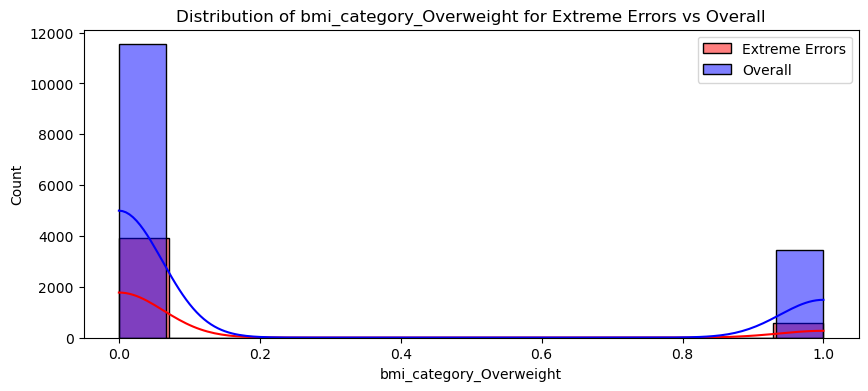

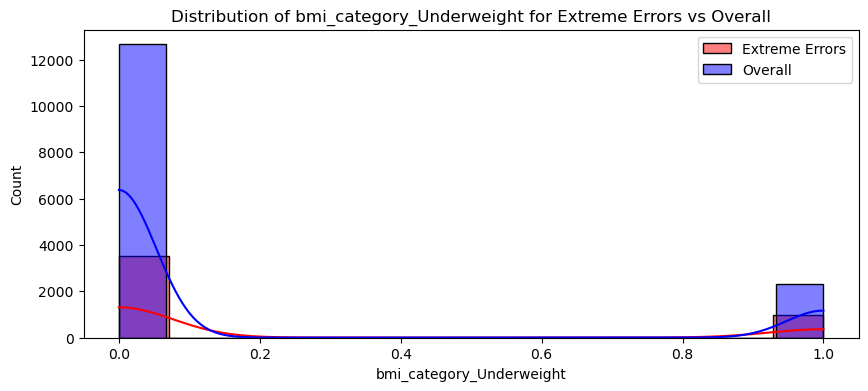

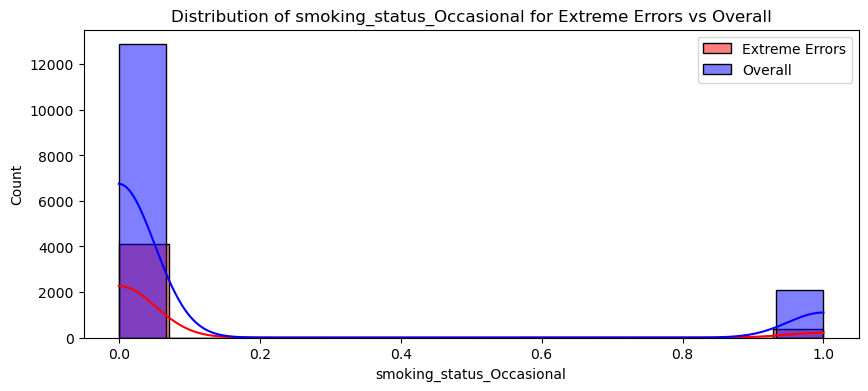

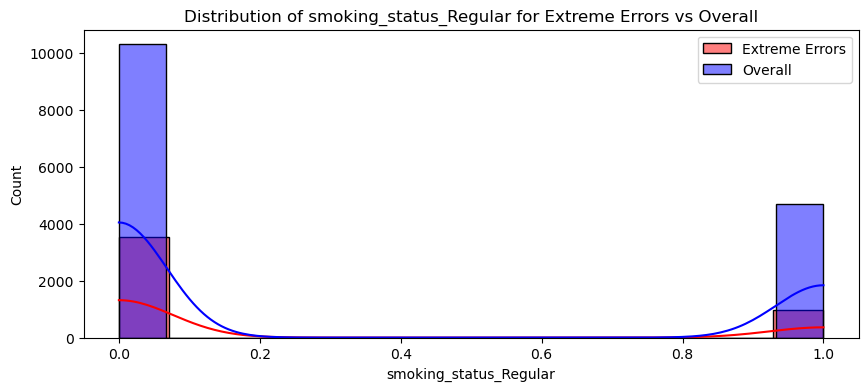

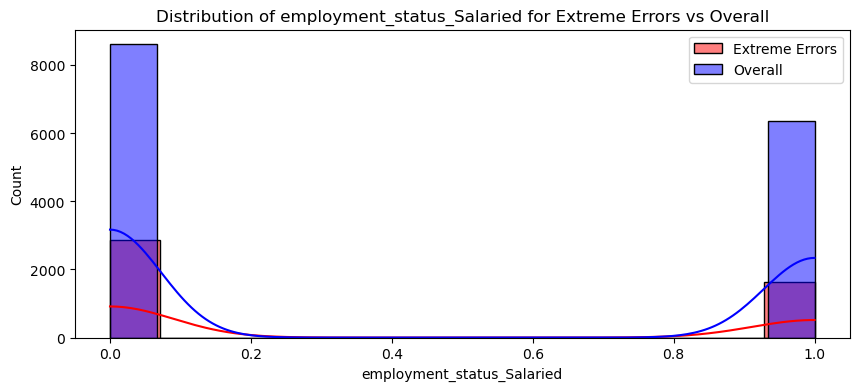

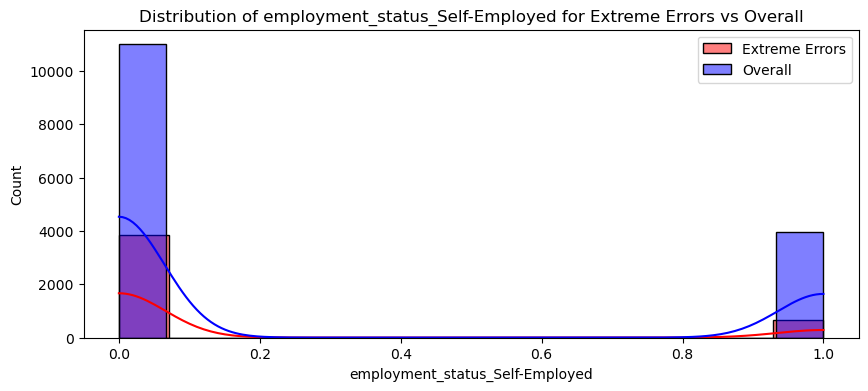

In [264]:
for feature in X_test.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(extreme_errors_df[feature], color='red', label='Extreme Errors', kde=True)
    sns.histplot(X_test[feature], color='blue', label='Overall', alpha=0.5, kde=True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.show()

In [266]:
extreme_errors_df['income_level']=-1

In [268]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,23.0,1.0,-2.0,14.0,1.0
1,19.0,1.0,-2.0,4.0,1.0
2,18.0,1.0,-2.0,3.0,1.0
3,21.0,0.0,-2.0,25.0,1.0
4,24.0,1.0,-2.0,8.0,2.0


In [270]:
df_reversed.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
count,4487.000000,4487.000000,4487.0,4487.000000,4487.000000
mean,21.804992,0.739247,-2.0,21.182527,1.302429
std,3.172355,0.968855,0.0,20.598596,0.563135
min,18.000000,0.000000,-2.0,1.000000,1.000000
25%,20.000000,0.000000,-2.0,6.000000,1.000000
50%,22.000000,0.000000,-2.0,15.000000,1.000000
75%,24.000000,1.000000,-2.0,30.000000,1.000000
max,60.000000,5.000000,-2.0,100.000000,3.000000


<Axes: xlabel='age', ylabel='Count'>

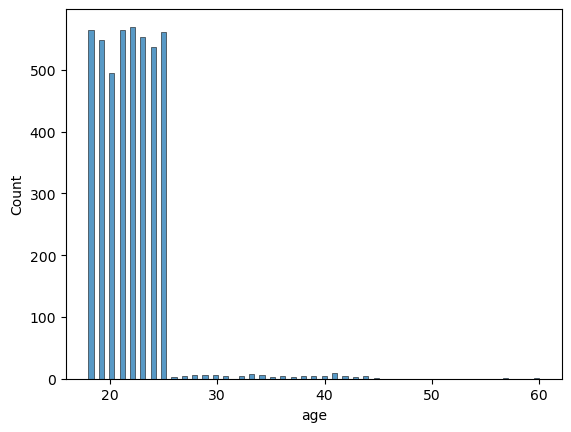

In [272]:
sns.histplot(df_reversed.age)